In [5]:
import os
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
noise_ratio = 0.5
content_image_max_L = 512 
style_image_max_L = 512 
style_loss_weight = np.array([0.5, 1.0, 1.5, 3.0, 4.0])
style_loss_weight /= np.sum(style_loss_weight)
content_weight = 1.0
style_weight = 0.01
tv_weight = 1e-4
learning_rate = 5.0
max_steps = 500
print_steps = 50

In [0]:
def vgg_19(inputs,
           reuse=False,
           scope='vgg_19'):
  """Oxford Net VGG 19-Layers version E Example
  
  My Note: This code is modified version of vgg_19 which is loacted on `models/research/slim/nets/vgg.py`
  Note: All the fully_connected layers have been transformed to conv2d layers.
        To use in classification mode, resize input to 224x224.

  Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    reuse: whether or not the model is being reused.
    scope: Optional scope for the variables.

  Returns:
    net: the output of the logits layer (if num_classes is a non-zero integer),
      or the input to the logits layer (if num_classes is 0 or None).
    end_points: a dict of tensors with intermediate activations.
  """
  with tf.variable_scope(scope, 'vgg_19', [inputs], reuse=reuse) as sc:
    end_points_collection = sc.original_name_scope + '_end_points'
    with slim.arg_scope([slim.conv2d, slim.avg_pool2d],
                        outputs_collections=end_points_collection):
      net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
      net = slim.avg_pool2d(net, [2, 2], scope='pool1')
      net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
      net = slim.avg_pool2d(net, [2, 2], scope='pool2')
      net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3')
      net = slim.avg_pool2d(net, [2, 2], scope='pool3')
      net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4')
      net = slim.avg_pool2d(net, [2, 2], scope='pool4')
      net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv5')
      end_points = slim.utils.convert_collection_to_dict(end_points_collection)
      return net, end_points

In [0]:
content_image_name = 'content.jpg'
style_image_name = 'style.jpg'

content_image_ = Image.open("content.jpg")
style_image_ = Image.open("style.jpg")

In [0]:
def image_resize_to_upper_bound(image, max_L=None):
  """Resize images
  
  Args:
    image: PIL image format
    max_L: upper bound of the image size
    
  Returns:
    image: resized image with PIL format
    h: resized height
    w: resized width
  """
  w, h = image.size
  if max_L is not None:
    if h < w:
      h = int(max_L * h / w)
      w = max_L
    else:
      w = int(max_L * w / h)
      h = max_L
    image = image.resize((w, h), Image.ANTIALIAS)
  
  return image, h, w

In [10]:
content_image_, content_image_h, \
content_image_w = image_resize_to_upper_bound(content_image_, content_image_max_L)
style_image_, style_image_h, \
style_image_w = image_resize_to_upper_bound(style_image_, style_image_max_L)
print('content_image size: height: {}  width: {}'.format(content_image_h, content_image_w))
print('style_image size: height: {}  width: {}'.format(style_image_h, style_image_w))

content_image size: height: 265  width: 512
style_image size: height: 512  width: 399


In [11]:
content_image_p = tf.placeholder(tf.float32, [1, content_image_h, content_image_w, 3])
style_image_p = tf.placeholder(tf.float32, [1, style_image_h, style_image_w, 3])

# Set the zero tensors to change from tf.placeholder to tf.Variable for content_image and style_image
content_image = tf.get_variable(name='content_image',
                                shape=[1, content_image_h, content_image_w, 3],
                                initializer=tf.zeros_initializer())
style_image = tf.get_variable(name='style_image',
                              shape=[1, style_image_h, style_image_w, 3],
                              initializer=tf.zeros_initializer())
# Set the random noise tensor with same shape of content_image for generated_iamge
generated_image = tf.get_variable(name='generated_image',
                                  shape=[1, content_image_h, content_image_w, 3],
                                  initializer=tf.random_uniform_initializer(minval=107,
                                                                            maxval=147))
# vgg preprocessing by mean_image_subtraction
# Chnage from tf.placeholder to tf.Variable
norm_means = np.array([123.68, 116.779, 103.939])
content_image_op = content_image.assign(content_image_p - norm_means)
style_image_op = style_image.assign(style_image_p - norm_means)
# Initial image is a mixture of content_image and random noise tensor
initial_image_op = generated_image.assign(generated_image * noise_ratio + \
                                          content_image_p * (1.0 - noise_ratio))

vgg_preprocessing_op = generated_image.assign(generated_image - norm_means)

# Clipping generated_image by below values in every iteration
min_vals = -norm_means
max_vals = 255. - norm_means
generated_image_clipping = generated_image.assign(tf.clip_by_value(generated_image,
                                                                   clip_value_min=min_vals,
                                                                   clip_value_max=max_vals))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
_, feature_maps_c = vgg_19(content_image) # input: content_image
_, feature_maps_s = vgg_19(style_image, reuse=True) # input: style_image
_, feature_maps_g = vgg_19(generated_image, reuse=True) # input: generated_image

In [0]:
with tf.Session() as sess:
  writer = tf.summary.FileWriter("graphs/01_style_transfer", sess.graph)
  writer.close()

In [0]:
content_layers = feature_maps_c['vgg_19/conv4/conv4_2']
style_layers = [feature_maps_s['vgg_19/conv1/conv1_1'],
                feature_maps_s['vgg_19/conv2/conv2_1'],
                feature_maps_s['vgg_19/conv3/conv3_1'],
                feature_maps_s['vgg_19/conv4/conv4_1'],
                feature_maps_s['vgg_19/conv5/conv5_1']]
generated_layers = [feature_maps_g['vgg_19/conv4/conv4_2'],
                    feature_maps_g['vgg_19/conv1/conv1_1'],
                    feature_maps_g['vgg_19/conv2/conv2_1'],
                    feature_maps_g['vgg_19/conv3/conv3_1'],
                    feature_maps_g['vgg_19/conv4/conv4_1'],
                    feature_maps_g['vgg_19/conv5/conv5_1']]

In [0]:
def content_loss(P, F, scope):
  """Calculate the content loss function between
  the feature maps of content image and generated image.
  
  Args:
    P: the feature maps of the content image
    F: the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: content loss (mean squared loss)
  """
  with tf.variable_scope(scope):
    assert F.shape == P.shape
    loss = tf.losses.mean_squared_error(F, P)
    #loss = 0.5 * tf.reduce_sum(tf.square(F - P)) # original loss on paper
  return loss

In [0]:
def style_loss(style_layers, generated_layers, scope):
  """Calculate the style loss function between
  the gram matrix of feature maps of style image and generated image.
  
  Args:
    style_layers: list of the feature maps of the style image
    generated_layers: list of the feature maps of the generated image
    scope: scope
    
  Returns:
    loss: style loss (mean squared loss)
  """
  def _style_loss_one_layer(feature_map_s, feature_map_g):
    """Calculate the style loss for one layer.
    
    Args:
      feature_map_s: the feature map of the style image
        - G: the gram matrix of the feature_map_s
      feature_map_g: the feature map of the generated image
        - A: the gram matrix of the feature_map_g
      
    Returns:
      loss: style loss for one layer (mean squared loss)
    """
    G = _gram_matrix(feature_map_s)
    A = _gram_matrix(feature_map_g)
    loss = tf.losses.mean_squared_error(G, A)
    return loss
  
  def _gram_matrix(feature_map):
    """Calculate the gram matrix for the feature map
    
    Args:
      feature_map: 4-rank Tensor [1, height, width, channels]
        - F = 2-rank Tensor [h * w, channels]
      
    Returns:
      gram_matrix: 2-rank Tensor [c, c] (F.transpose x F)
    """
    F = tf.squeeze(feature_map, axis=0)
    h, w, c = F.get_shape().as_list()
    F = tf.reshape(F, [h * w, c])
    
    gram_matrix = tf.matmul(tf.transpose(F), F) / (h * w)
    return gram_matrix
    
  with tf.variable_scope(scope):
    assert len(style_layers) == len(generated_layers)
  
    loss = 0.0
    for i in range(len(style_layers)):
      loss_one = _style_loss_one_layer(style_layers[i], generated_layers[i])
      loss += loss_one * style_loss_weight[i]

  return loss

In [17]:
loss_c = content_loss(content_layers, generated_layers[0],
                      scope='content_loss') * content_weight
loss_s = style_loss(style_layers, generated_layers[1:],
                    scope='style_loss') * style_weight
total_variation = tf.squeeze(tf.image.total_variation(generated_image),
                             name='total_variation') * tv_weight

with tf.variable_scope('total_loss'):
  total_loss = loss_c + loss_s + total_variation

Instructions for updating:
Use tf.cast instead.


In [18]:
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = opt.minimize(total_loss, var_list=generated_image)

Instructions for updating:
Use tf.cast instead.


In [0]:
def preprocessing(image):
  """image preprocessing

  Args:
    image (PIL image): image with shape [height, width, channels]
    
  Returns:
    image (np.float32): numpy type 4-rank tensor shape [1, height, width, channels]
  """
  image = np.asarray(image)
  image = image.astype(np.float32)
  image = np.expand_dims(image, axis=0)
  
  return image

In [0]:
def print_image(image):
  """print image
  
  Args:
    image (np.float32): 4-rank np.array [1, height, width, 3]
  """
  print_image = deprocess_image(image)
  plt.axis('off')
  plt.imshow(print_image)
  plt.show()

In [0]:
def deprocess_image(image):
  """vgg image deprocessing.
  
  Args:
    image (np.float32): 4-rank np.array [1, height, width, 3]
  
  Returns:
    image_ (np.uint8): image applied by mean_image_addition and cast type
  """
  image_ = copy.deepcopy(image)
  image_ = np.squeeze(image_, axis=0)
  image_[:, :, 0] += 123.68
  image_[:, :, 1] += 116.779
  image_[:, :, 2] += 103.939
  image_ = np.clip(image_, 0, 255).astype('uint8')
  
  return image_

In [0]:
content_image_ = preprocessing(content_image_)
style_image_ = preprocessing(style_image_)

In [0]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

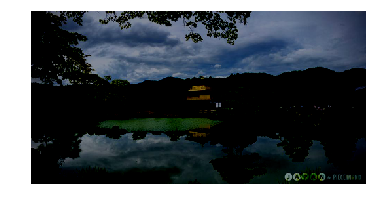

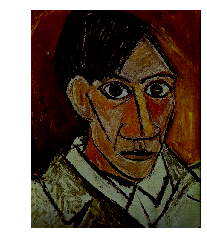

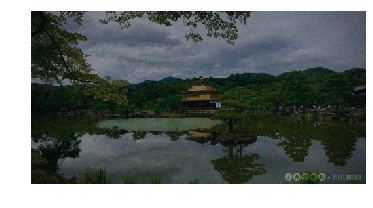

INFO:tensorflow:Restoring parameters from vgg_19.ckpt
step: 50  total_loss: 2976682.25  loss_c: 225067.828125  loss_s: 2750069.75  total_variation: 1544.6417236328125  duration: 22.448402166366577


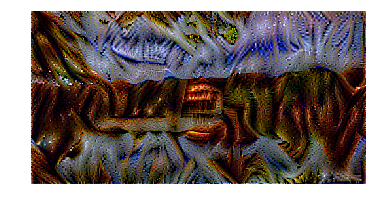

step: 100  total_loss: 1636313.875  loss_c: 231624.25  loss_s: 1403105.625  total_variation: 1584.0604248046875  duration: 14.745672464370728


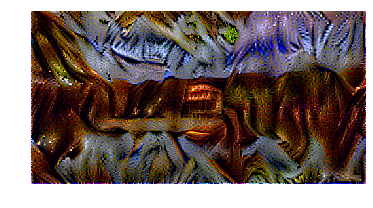

step: 150  total_loss: 1227814.375  loss_c: 235638.421875  loss_s: 990545.75  total_variation: 1630.3109130859375  duration: 14.70819878578186


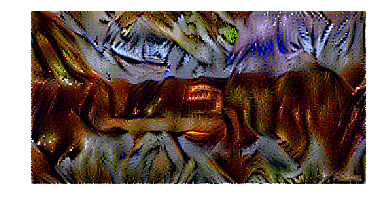

step: 200  total_loss: 1026430.8125  loss_c: 238536.328125  loss_s: 786227.3125  total_variation: 1667.197509765625  duration: 14.7311429977417


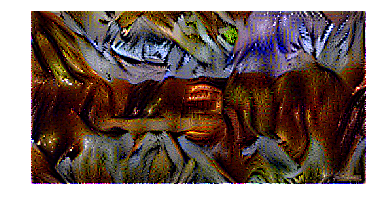

step: 250  total_loss: 902860.4375  loss_c: 240470.46875  loss_s: 660693.4375  total_variation: 1696.568359375  duration: 14.697946786880493


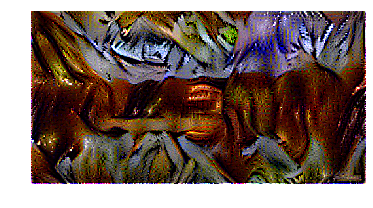

step: 300  total_loss: 827290.125  loss_c: 241639.0625  loss_s: 583929.0625  total_variation: 1722.0015869140625  duration: 14.702259063720703


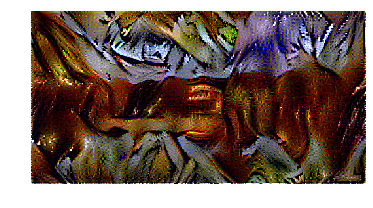

step: 350  total_loss: 771596.5625  loss_c: 242789.671875  loss_s: 527062.5625  total_variation: 1744.3048095703125  duration: 14.693870306015015


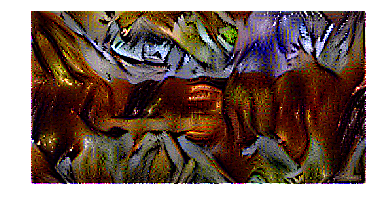

step: 400  total_loss: 749566.5  loss_c: 242855.09375  loss_s: 504948.03125  total_variation: 1763.343994140625  duration: 14.689011573791504


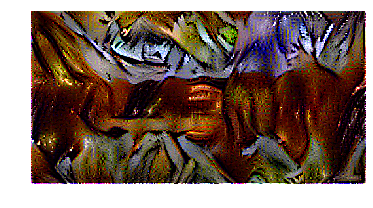

step: 450  total_loss: 706399.9375  loss_c: 244353.578125  loss_s: 460264.0  total_variation: 1782.3983154296875  duration: 14.702307939529419


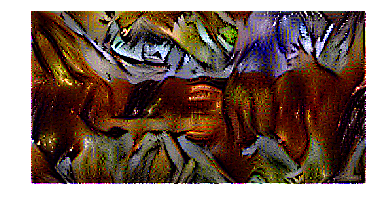

step: 500  total_loss: 693240.1875  loss_c: 244006.34375  loss_s: 447434.21875  total_variation: 1799.61474609375  duration: 14.697831630706787


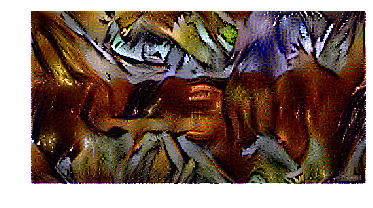

training done!


In [27]:
v = tf.get_collection(tf.GraphKeys.MODEL_VARIABLES, scope='vgg_19')
saver = tf.train.Saver(var_list=v)

with tf.Session(config=sess_config) as sess:
  sess.run(tf.global_variables_initializer())
  # Change from tf.placeholder to Variable for content_image_ and style_image_
  sess.run([content_image_op, style_image_op],
           feed_dict={content_image_p: content_image_,
                      style_image_p: style_image_})
  sess.run(initial_image_op, feed_dict={content_image_p: content_image_})
  sess.run(vgg_preprocessing_op)
  sess.run(generated_image_clipping)
  
  content_image_, style_image_, generated_image_ = sess.run([content_image,
                                                             style_image,
                                                             generated_image])
  print_image(content_image_)
  print_image(style_image_)
  print_image(generated_image_) 

  saver.restore(sess, "vgg_19.ckpt")
  
  start_time = time.time()
  for step in range(max_steps):
    _, loss_, loss_c_, loss_s_, tv_, _ = \
        sess.run([train_op, total_loss,
                  loss_c, loss_s, total_variation,
                  generated_image_clipping])
    generated_image_ = sess.run(generated_image)
    if (step+1) % print_steps == 0:
      duration = time.time() - start_time
      print("step: {}  total_loss: {}  loss_c: {}  loss_s: {}  total_variation: {}  duration: {}".format((step+1), loss_, loss_c_, loss_s_, tv_, duration))
      print_image(generated_image_)
      start_time = time.time()
  print('training done!')